In [40]:
import numpy as np
import pandas as pd
import scipy.io
import os
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.metrics import plot_confusion_matrix, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras.applications import VGG16, ResNet50, ResNet101V2, InceptionV3
import efficientnet.tfkeras as efn


np.random.seed(6)

### Loading in class names from Matlab files

In [3]:
meta = scipy.io.loadmat('files/devkit/cars_meta.mat')
train = scipy.io.loadmat('files/devkit/cars_train_annos.mat')
test = scipy.io.loadmat('files/devkit/cars_test_annos.mat')

In [4]:
classes = pd.DataFrame(meta['class_names'][0], columns=['title'])

In [5]:
classes['title']
classes_list = []
for value in classes['title']:
    value = value[0]
    classes_list.append(value)
    
classes['title'] = classes_list

In [6]:
classes['title']

0            AM General Hummer SUV 2000
1                   Acura RL Sedan 2012
2                   Acura TL Sedan 2012
3                  Acura TL Type-S 2008
4                  Acura TSX Sedan 2012
                     ...               
191    Volkswagen Beetle Hatchback 2012
192            Volvo C30 Hatchback 2012
193                Volvo 240 Sedan 1993
194                 Volvo XC90 SUV 2007
195       smart fortwo Convertible 2012
Name: title, Length: 196, dtype: object

### Redefining classes from make, model and year to just make

In [7]:
makes = []
for value in classes['title']:
    value = value.split(' ')[0]
    makes.append(value)
    
classes['makes'] = makes

classes['makes'].head()

0       AM
1    Acura
2    Acura
3    Acura
4    Acura
Name: makes, dtype: object

### Grabbing image class labels and bounding boxes from Matlab files

In [8]:
train_file_name_list = []
train_image_bounds = []
train_label_name_list = []
bounds_box = []
for i in range(train['annotations'].shape[1]):
    train_file_name_list.append(train['annotations'][:,i][0][5][0])
    train_label_name_list.append(train['annotations'][:,i][0][4][0][0])
    train_bounds_list = []
    image_bounds_list = []
    for j in range(5):
        train_bounds_list.append(train['annotations'][:,i][0][j][0][0])
    train_image_bounds.append(train_bounds_list)     
    for k in range(4):
        image_bounds_list.append(train['annotations'][:,i][0][k][0][0])
    bounds_box.append(image_bounds_list)   

In [9]:
bounds_box[:5]

[[39, 116, 569, 375],
 [36, 116, 868, 587],
 [85, 109, 601, 381],
 [621, 393, 1484, 1096],
 [14, 36, 133, 99]]

In [10]:
test_file_name_list = []
test_image_bounds = []
for i in range(test['annotations'].shape[1]):
    test_file_name_list.append(test['annotations'][:,i][0][4][0])
    test_bounds_list = []
    for j in range(4):
        test_bounds_list.append(test['annotations'][:,i][0][j][0][0])
    test_image_bounds.append(test_bounds_list)

In [11]:
test_image_bounds[:5]

[[30, 52, 246, 147],
 [100, 19, 576, 203],
 [51, 105, 968, 659],
 [67, 84, 581, 407],
 [140, 151, 593, 339]]

In [12]:
train_df_box = pd.DataFrame(train_image_bounds, columns=['X1', 'X2', 'Y1', 'Y2', 'label'])
train_df_box.head()

,X1,X2,Y1,Y2,label
0,39,116,569,375,14
1,36,116,868,587,3
2,85,109,601,381,91
3,621,393,1484,1096,134
4,14,36,133,99,106


In [13]:
test_df_box = pd.DataFrame(test_image_bounds, columns=['X1', 'X2', 'Y1', 'Y2'])
test_df_box.head()

,X1,X2,Y1,Y2
0,30,52,246,147
1,100,19,576,203
2,51,105,968,659
3,67,84,581,407
4,140,151,593,339


### Creating Dataframe with file names and image class labels

In [14]:
file_df = pd.DataFrame(train_file_name_list, train_df_box['label'], columns =['file'])

In [15]:
file_df.reset_index(inplace=True)

In [16]:
# redifining from 196 classes to 48 classes
file_df['label'] = file_df['label'].map(classes['makes'])

In [17]:
file_df['label'].isnull().sum()

40

In [18]:
file_df = file_df[file_df['label'].notnull()].copy()

In [19]:
#create numerical value label for each car make
file_df['label'] = pd.Categorical(file_df['label']).codes

In [20]:
#make each label into a list of its own for the image data generator
file_df['label'] = file_df['label'].apply(lambda x: str(x).split(' '))

In [21]:
file_df

,label,file
0,[2],00001.jpg
1,[0],00002.jpg
2,[11],00003.jpg
3,[21],00004.jpg
4,[16],00005.jpg
...,...,...
8138,[44],08139.jpg
8139,[9],08140.jpg
8141,[33],08142.jpg
8142,[16],08143.jpg


### Using Image Data Generator's flow from directory function to create training/validation images

In [ ]:
# For ease of testing, I am utilizing only the labeled training dataset and splitting a 
# validation set from this in the image data generator

In [22]:
# Scaling data by dividing by 255 (value range for pixels is 0-255), and splitting 20%
# for testing set
data_generator = ImageDataGenerator(rescale=1./255., validation_split=.2)

In [23]:
# Augmenting images in the image data generator under the training dataset 
# to give model more training data

train_generator = data_generator.flow_from_dataframe(
    dataframe=file_df,
    directory='files/cars_train/',
    x_col='file',
    y_col='label',
    subset="training",
    seed=42,
    shuffle=True,
    rotation_range=180,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    target_size=(224, 224),
    batch_size=64,
    class_mode="categorical")

# not augmenting testing data, just used to create more images for training
test_generator = data_generator.flow_from_dataframe(
    dataframe=file_df,
    directory='files/cars_train/',
    x_col='file',
    y_col='label',
    subset="validation",
    seed=42,
    shuffle=False,
    target_size=(224, 224),
    batch_size=64,
    class_mode="categorical")

Found 6484 validated image filenames belonging to 48 classes.
Found 1620 validated image filenames belonging to 48 classes.


In [24]:
train_generator[0][0][0].shape

(224, 224, 3)

# Building the Model

### Encorporating a pretrained EfficientNetB0 into the beginning of my model

In [25]:
efficient = efn.EfficientNetB0(weights='imagenet', include_top=False, 
                       input_shape=(224, 224, 3))

for layer in efficient.layers[:]:
    layer.trainable = False

16809984/16804768 [==============================] - 17s 1us/step


In [26]:
model = Sequential()

model.add(efficient)

#Input shape of following conv2D layer is output shape of EfficientNetB0 layer

model.add(Conv2D(filters=1024,           
                     kernel_size=(3, 3),
                     activation='relu',     
                     input_shape=(7, 7, 1280)))


model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))

model.add(Dense(512, activation='relu'))

model.add(Dense(256, activation='relu'))

model.add(Dense(128, activation='relu'))

model.add(Dense(128, activation='relu'))

model.add(Dense(48, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=.001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### Model Summary showing 1 input model layer, 8 hidden layers, and 1 output layer

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 1024)        11797504  
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 1024)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               2097664   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1

### Fitting the model for 25 epochs

In [28]:
history = model.fit(train_generator, validation_data=test_generator, epochs=25, verbose=1)

Epoch 1/25
102/102 [==============================] - 346s 3s/step - loss: 4.1481 - accuracy: 0.1027 - val_loss: 3.0338 - val_accuracy: 0.1852
Epoch 2/25
102/102 [==============================] - 2223s 22s/step - loss: 2.9163 - accuracy: 0.2049 - val_loss: 2.7301 - val_accuracy: 0.2463
Epoch 3/25
102/102 [==============================] - 1149s 4s/step - loss: 2.4558 - accuracy: 0.3016 - val_loss: 2.5328 - val_accuracy: 0.2944
Epoch 4/25
102/102 [==============================] - 357s 3s/step - loss: 2.0041 - accuracy: 0.4186 - val_loss: 2.4413 - val_accuracy: 0.3086
Epoch 5/25
102/102 [==============================] - 359s 4s/step - loss: 1.5667 - accuracy: 0.5295 - val_loss: 2.3628 - val_accuracy: 0.3704
Epoch 6/25
102/102 [==============================] - 348s 3s/step - loss: 1.1937 - accuracy: 0.6321 - val_loss: 2.5631 - val_accuracy: 0.3679
Epoch 7/25
102/102 [==============================] - 369s 4s/step - loss: 0.9356 - accuracy: 0.7122 - val_loss: 2.4399 - val_accuracy: 0.4

### Plotting Loss and Accuracy for the model

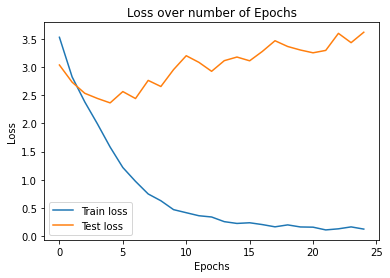

In [29]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over number of Epochs')
plt.legend();

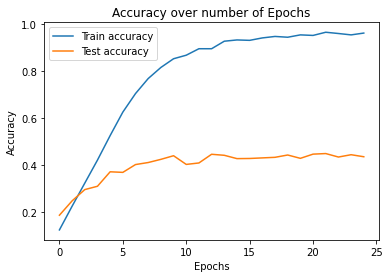

In [30]:
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over number of Epochs')
plt.legend();

In [32]:
predictions = model.predict(test_generator)

In [33]:
predicted_classes = np.argmax(predictions, axis=1)

In [34]:
true_classes = test_generator.classes

In [35]:
class_labels = list(test_generator.class_indices.keys()) 

In [46]:
confusion_matrix(true_classes, predicted_classes)

array([[ 19,   0,   0, ...,   0,   3,   0],
       [  1,  12,   0, ...,   0,   0,   0],
       [  0,   0,   2, ...,   0,   0,   2],
       ...,
       [  1,   0,   0, ...,   6,   0,   0],
       [  4,   0,   0, ...,   3, 100,   7],
       [  0,   2,   0, ...,   0,   9,  14]])